# SAC (Soft Actor-Critic)

SAC (Soft Actor-Critic) is one of today's popular algorithm, which is based on **off-policy** DDPG discussed in [here](./05-ddpg.ipynb).<br>
However, unlike DDPG, SAC applies entropy regularization and trains a stochastic policy, not a deterministic policy.

Entropy is defined as $ H(P) = -\int P(x) \log P(x) = E_x[-\log P(x)] $ and it how it's distributed.<br>
For instance, if it has 8 possible states, each of which is equally likely in discrete distribution, it will have $ H(P) = -\sum P(x) \log P(x) = -8 \times \frac{1}{8} \log_2 \frac{1}{8} = 3 $. (This implies that it needs 3 bits evenly.) If the distribution is $ (\frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \frac{1}{16}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}) $, it will have $ H(P) = -\frac{1}{2} \log_2 \frac{1}{2} - \frac{1}{4} \log_2 \frac{1}{4} - \frac{1}{8} \log_2 \frac{1}{8} - \frac{1}{16} \log_2 \frac{1}{16} - 4 \times \frac{1}{64} \log_2 \frac{1}{64} = 2 $.<br>
(Note that, for simplicity, I have replaced the base of logarithm with 2.)<br>

Entropy will be larger, when the distribution has much randomness.

> Note : In continuous distribution, it's known that the distribution that maximizes the entropy is Gaussian distribution. Here I don't go detail, but KL-divergence (the penalty for large updates) discussed in [PPO](./04-ppo.ipynb) is closely related with this entropy term.

Instead of a reward expectation $ r_t + \gamma (d_t - 1) Q_{{\phi}^{\prime}} $ used in DDPG, SAC will apply $ r_t + \gamma (d_t - 1) (Q_{{\phi}^{\prime}} + \alpha H(P)) $ (where $\alpha$ is a coefficient parameter for entropy weight) in order to balance between exploitation and exploration.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

In [ ]:
!pip install numpy gym　tensorflow==2.4 matplotlib

In [1]:
import random
import gym
import numpy as np
import tensorflow as tf

Unlike [DDPG](./05-ddpg.ipynb), we can use discrete action space in SAC. (See below for reasons.)

In [2]:
env = gym.make("CartPole-v0")

Unlike DDPG, SAC trains a stochastic policy $ \pi_{\theta}(\cdot) $ (where $ \theta $ is parameters) instead of a deterministic policy $ \mu_{\theta}(\cdot) $. (And we don't use target policy network $ \pi_{\theta^{\prime}} $.)<br>
In this example, I set a policy $ P(\cdot | \pi_\theta(s)) $ as a categorical distribution (same as, used in [policy gradient](./02-policy-gradient.ipynb) and [PPO](./04-ppo.ipynb) example), because it's discrete action space:

> Note : For the bounded continuous action space between $ l $ and $ h $, use Gaussian distribution as follows.<br>
> $ P(\cdot | \pi_\theta(s)) = ((tanh(\mathcal{N}(\mu_{\theta}(s), \sigma_{\theta}(s))) + 1.0) / 2.0) \times (h - l) + l  $

Because we use a stochastic policy, we don't then need Ornstein-Uhlenbeck noise used in [DDPG](./05-ddpg.ipynb).

In [3]:
# origin policy net (pi_theta)
s_input_actor = tf.keras.layers.Input(shape=(4, ))
last_actor = tf.keras.layers.Dense(64,activation='relu')(s_input_actor)
output_actor = tf.keras.layers.Dense(2,activation=None)(last_actor)
pi_model = tf.keras.Model([s_input_actor], output_actor)

# pick up action
def pick_sample(s):
    logits = pi_model(tf.cast(np.array([s]), tf.float32))
    sample_t = tf.random.categorical(logits, 1)
    sample_t = tf.squeeze(sample_t, axis=1)
    return int(sample_t.numpy()[0])

Same as DDPG with clipped double-Q (see [here](./05-ddpg.ipynb)), we use 2 Q-networks - $ Q_{\phi_1}(s), Q_{\phi_2}(s) $ - and corresponding 2 target networks - $ Q_{\phi_1^{\prime}}(s), Q_{\phi_2^{\prime}}(s) $.

You will find that this is different from the one used in [DDPG](./05-ddpg.ipynb).<br>
For categorical distribution with the depth n (in this example, n=2), the output of $ Q(\cdot) $ is n-dimensional tensor, in which each element represents the expectation of Q-value for the corresponding action. And we use $ Q(s) \cdot \tilde{a} $ (i.e, dot product) instead of $ Q(s, a) $, where $ \tilde{a} $ is one hot tensor for action $ a $.

In [4]:
# origin Q net 1 (Q_phi1)
s_input_critic1 = tf.keras.layers.Input(shape=(4, ))
last_critic1 = tf.keras.layers.Dense(64,activation='relu')(s_input_critic1)
output_critic1 = tf.keras.layers.Dense(2,activation=None)(last_critic1)
q_model1 = tf.keras.Model([s_input_critic1], output_critic1)

# origin Q net 2 (Q_phi2)
s_input_critic2 = tf.keras.layers.Input(shape=(4, ))
last_critic2 = tf.keras.layers.Dense(64,activation='relu')(s_input_critic2)
output_critic2 = tf.keras.layers.Dense(2,activation=None)(last_critic2)
q_model2 = tf.keras.Model([s_input_critic2], output_critic2)

# target Q net 1 (Q_phi1')
s_input_critic_tg1 = tf.keras.layers.Input(shape=(4, ))
last_critic_tg1 = tf.keras.layers.Dense(64,activation='relu')(s_input_critic_tg1)
output_critic_tg1 = tf.keras.layers.Dense(2,activation=None)(last_critic_tg1)
q_tg_model1 = tf.keras.Model([s_input_critic_tg1], output_critic_tg1)

# target Q net 2 (Q_phi2')
s_input_critic_tg2 = tf.keras.layers.Input(shape=(4, ))
last_critic_tg2 = tf.keras.layers.Dense(64,activation='relu')(s_input_critic_tg2)
output_critic_tg2 = tf.keras.layers.Dense(2,activation=None)(last_critic_tg2)
q_tg_model2 = tf.keras.Model([s_input_critic_tg2], output_critic_tg2)

As we saw in [DDPG with clipped double-Q](./05-ddpg.ipynb), we optimize policy parameter $ \theta $ to maximize $ Q_{\phi_1}(s, a^*) + \alpha H(P(\cdot | \pi_\theta(s))) $ where $ a^* $ is an optimal action.

As I have mentioned above, $ H(P) = E_x[-\log P(x)] $.<br>
In this categorical distribution (in discrete action space), $ H $ will be the following dot product :

$ H(P) = H(P(\cdot | \pi_\theta(s))) = -\pi_\theta(s) \cdot \log \pi_\theta(s) $

where $ \pi_\theta(s) $ is one hot probability.

For $ Q(s, a^*) $ term, it will become the following dot product. (See above for reason.) :

$ Q_{\phi_1}(s, a^*) = Q_{\phi_1}(s) \cdot \pi_\theta(s) $

To summarize, we should optimize $ \theta $ to maximize :

$ E\left[ \pi_\theta(s) \cdot Q_{\phi_1}(s) - \alpha \pi_\theta(s) \cdot \log \pi_\theta(s) \right] = E\left[ \pi_\theta(s) \cdot (Q_{\phi_1}(s) - \alpha \log \pi_\theta(s)) \right] $

> Note : Here I used a constant $ \alpha $, but there exists a variation of SAC, in which $ \alpha $ is also learned over the course of training.

In [5]:
alpha = 1.0

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

class categorical:
    def __init__(self, s, training=False):
        self.state_t = s
        self._logits = pi_model([self.state_t], training=training)
        self._logp = tf.nn.log_softmax(self._logits, axis=-1)
        self._prob = tf.math.exp(self._logp)

    # probability (the sum is 1.0)
    def prob(self):
        return self._prob

    # log probability : log P()
    def logp(self):
        return self._logp

def optimize_theta(states):
    states_t = tf.convert_to_tensor(states)

    # actor loss
    with tf.GradientTape() as tape:
        dist = categorical(states_t, training=True)
        q1_t = q_model1(states_t, training=True)
        actor_loss_t = tf.multiply(
            dist.prob(),
            tf.stop_gradient(q1_t) - alpha * dist.logp()
        )
        actor_loss_t = -tf.reduce_sum(actor_loss_t, axis=-1)
        actor_loss_t = tf.reduce_mean(actor_loss_t)

    # optimize actor
    grad_a = tape.gradient(
        actor_loss_t,
        pi_model.trainable_variables)
    opt.apply_gradients(zip(grad_a, pi_model.trainable_variables))

Same as we saw in [DDPG with clipped double-Q](./05-ddpg.ipynb), we optimize parameter $ \phi_1, \phi_2 $ as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (d_t - 1) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (d_t - 1) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $

in which :

- $ Q_{\phi_i}(s_t, a_t) = Q_{\phi_i}(s_t) \cdot \tilde{a_t} $ where $ \tilde{a_t} $ is one hot vector of $ a_t $
- $ Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) =  Q_{\phi_1}(s_{t+1}) \cdot \pi_\theta(s_{t+1}) $ where $ \pi_\theta(s_{t+1}) $ is one hot probability
- $ H(P(\cdot | \pi_\theta(s_{t+1}))) = -\pi_\theta(s_{t+1}) \cdot \log \pi_\theta(s_{t+1}) $

In [6]:
gamma = 0.99

def optimize_phi(states, actions, rewards, next_states, dones):
    states_t      = tf.convert_to_tensor(states)
    actions_t     = tf.convert_to_tensor(actions)
    rewards_t     = tf.convert_to_tensor(rewards)
    next_states_t = tf.convert_to_tensor(next_states)
    dones_t       = tf.convert_to_tensor(dones)

    # critic loss (Q-network 1)
    with tf.GradientTape() as tape:
        logits_t = pi_model([next_states_t], training=True)
        next_q_tg_t1 = q_tg_model1([next_states_t], training=True)
        next_q_tg_t2 = q_tg_model2([next_states_t], training=True)
        next_q_tg_t = tf.reduce_min((next_q_tg_t1, next_q_tg_t2), axis=0)
        dist_next = categorical(next_states_t, training=True)
        next_q_tg_t = next_q_tg_t - alpha * dist_next.logp()
        mul_t = tf.multiply(dist_next.prob(), next_q_tg_t)
        dot_product_t = tf.reduce_sum(mul_t, axis=-1, keepdims=True)
        q_tg_t = tf.stop_gradient(rewards_t + gamma * (1.0 - dones_t) * dot_product_t)

        one_hot_t = tf.one_hot(actions_t, depth=2)
        one_hot_t = tf.squeeze(one_hot_t, axis=1)
        q_t1 = q_model1([states_t], training=True)
        q_t1 = tf.reduce_sum(q_t1 * one_hot_t, axis=-1, keepdims=True)
        critic_loss_suqares_t1 = tf.math.square(q_t1 - q_tg_t)
        critic_loss_t1 = tf.reduce_mean(critic_loss_suqares_t1)

    # optimize critic (Q-network 1)
    grad_q1 = tape.gradient(
        critic_loss_t1,
        q_model1.trainable_variables)
    opt.apply_gradients(zip(grad_q1, q_model1.trainable_variables))

    # critic loss (Q-network 2)
    with tf.GradientTape() as tape:
        logits_t = pi_model([next_states_t], training=True)
        next_q_tg_t1 = q_tg_model1([next_states_t], training=True)
        next_q_tg_t2 = q_tg_model2([next_states_t], training=True)
        next_q_tg_t = tf.reduce_min((next_q_tg_t1, next_q_tg_t2), axis=0)
        dist_next = categorical(next_states_t, training=True)
        next_q_tg_t = next_q_tg_t - alpha * dist_next.logp()
        mul_t = tf.multiply(dist_next.prob(), next_q_tg_t)
        dot_product_t = tf.reduce_sum(mul_t, axis=-1, keepdims=True)
        q_tg_t = tf.stop_gradient(rewards_t + gamma * (1.0 - dones_t) * dot_product_t)

        one_hot_t = tf.one_hot(actions_t, depth=2)
        one_hot_t = tf.squeeze(one_hot_t, axis=1)
        q_t2 = q_model2([states_t], training=True)
        q_t2 = tf.reduce_sum(q_t2 * one_hot_t, axis=-1, keepdims=True)
        critic_loss_suqares_t2 = tf.math.square(q_t2 - q_tg_t)
        critic_loss_t2 = tf.reduce_mean(critic_loss_suqares_t2)

    # optimize critic (Q-network 2)
    grad_q2 = tape.gradient(
        critic_loss_t2,
        q_model2.trainable_variables)
    opt.apply_gradients(zip(grad_q2, q_model2.trainable_variables))

As we saw in [DDPG with clipped double-Q](./05-ddpg.ipynb), target parameters $\phi_1^{\prime}, \phi_2^{\prime}$ are delayed with coefficient parameter (hyper-parameter) $ \tau $.

In [7]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_model1.variables, q_tg_model1.variables):
        var_target.assign(tau * var + (1.0 - tau) * var_target)
    for var, var_target in zip(q_model2.variables, q_tg_model2.variables):
        var_target.assign(tau * var + (1.0 - tau) * var_target)

As we saw in [DDPG](./05-ddpg.ipynb), we use replay buffer to prevent from learning only for recent experiences.

In [8]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0] for i in indices]
        actions  = [[self.buffer[i][1]] for i in indices]
        rewards  = [[self.buffer[i][2]] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [[self.buffer[i][4]] for i in indices]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(20000)

Now let's put it all together !

In [9]:
batch_size = 250

reward_records = []
for i in range(1000):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, done, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize_theta(states)
            optimize_phi(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 200)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 195.0
    reward_records_np = np.array(reward_records)
    if np.average(reward_records_np[-50:]) > 195.0:
        break

env.close()
print("\nDone")

Run episode196 with rewards 200.0
Done


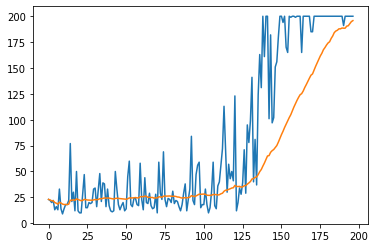

In [10]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
reward_records_np = np.array(reward_records)
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records_np[:idx+1]
    else:
        avg_list = reward_records_np[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)